In [13]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
from collections import Counter
import cpi
import ast
import json
import datetime
from sklearn.decomposition import PCA
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from wordcloud import WordCloud, STOPWORDS 

In [2]:
# Common functions

# Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

def plot_itemset(title, result, dataset_size, rotation=90):
    plt.figure(figsize=(20,12))
    sns.barplot([", ".join(list(x)) for x in result["itemsets"]], [x * dataset_size for x in result["support"]])
    plt.xticks(fontsize=12,rotation=rotation)
    plt.title(title,fontsize=20)
    plt.show()

In [3]:
# Datasets loading
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset = dataset_original

oscars = pd.read_csv('./tmdb-box-office-prediction/the_oscar_award.csv')
oscars_winners = oscars[oscars["winner"] == True].drop(columns=["winner", "year_film", "year_ceremony", "ceremony", "category", "name"])
oscars_winners = oscars_winners[oscars_winners["film"].notnull()]
dataset_lc = dataset.copy()
oscars_winners_lc = oscars_winners.copy()
dataset_lc['title'] = dataset_lc['title'].str.lower()
oscars_winners_lc['film'] = oscars_winners_lc['film'].str.lower()
oscar_movies = pd.merge(left=dataset_lc, right=oscars_winners_lc, left_on='title', right_on='film').drop_duplicates(subset='id')
oscar_movies = oscar_movies.drop(columns=['film'])

dataset = text_to_dict(dataset)
oscar_movies = text_to_dict(oscar_movies)

In [4]:
oscar_movies.info()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 516
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     227 non-null    int64  
 1   belongs_to_collection  227 non-null    object 
 2   budget                 227 non-null    int64  
 3   genres                 227 non-null    object 
 4   homepage               73 non-null     object 
 5   imdb_id                227 non-null    object 
 6   original_language      227 non-null    object 
 7   original_title         227 non-null    object 
 8   overview               227 non-null    object 
 9   popularity             227 non-null    float64
 10  poster_path            227 non-null    object 
 11  production_companies   227 non-null    object 
 12  production_countries   227 non-null    object 
 13  release_date           227 non-null    object 
 14  runtime                227 non-null    float64
 15  spoken

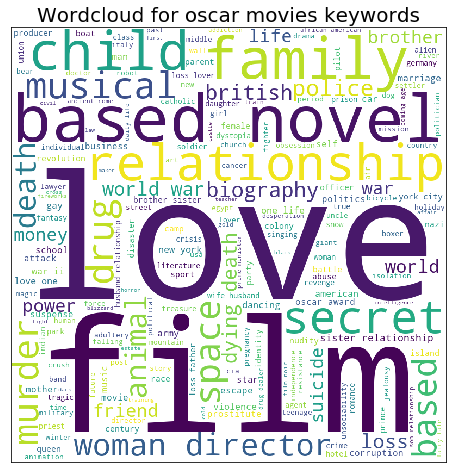

In [5]:
# Keyword words cloud analysis
def createWordCloudForWordsString(wordsString):
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(wordsString) 
    return wordcloud

keywordsMovieDataset = oscar_movies[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset.explode('Keywords').reset_index(drop=True)
keywordsList = keywordsMovieDataset['Keywords'].values.tolist()

oscarMoviesKeywords = ' '

for word in keywordsList: 
    oscarMoviesKeywords = oscarMoviesKeywords + str(word) + ' '

# Plot oscar movies keywords wordcloud                
plt.figure(figsize = (8, 8)) 
plt.imshow(createWordCloudForWordsString(oscarMoviesKeywords)) 
plt.title("Wordcloud for oscar movies keywords",fontsize=20)  
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show() 

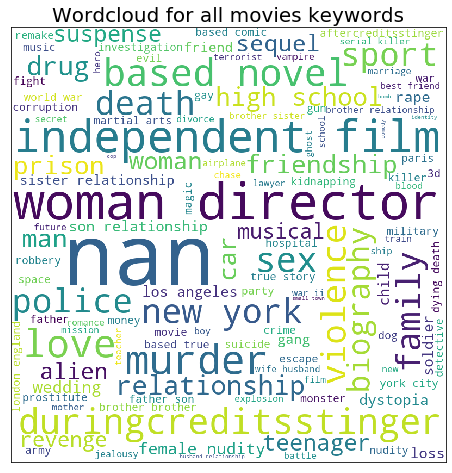

In [6]:
keywordsMovieDataset = dataset[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset.explode('Keywords').reset_index(drop=True)
keywordsList = keywordsMovieDataset['Keywords'].values.tolist()

allMoviesKeywords = ' '

for word in keywordsList: 
    allMoviesKeywords = allMoviesKeywords + str(word) + ' '

# Plot oscar movies keywords wordcloud                
plt.figure(figsize = (8, 8)) 
plt.imshow(createWordCloudForWordsString(allMoviesKeywords)) 
plt.title("Wordcloud for all movies keywords",fontsize=20)  
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show() 

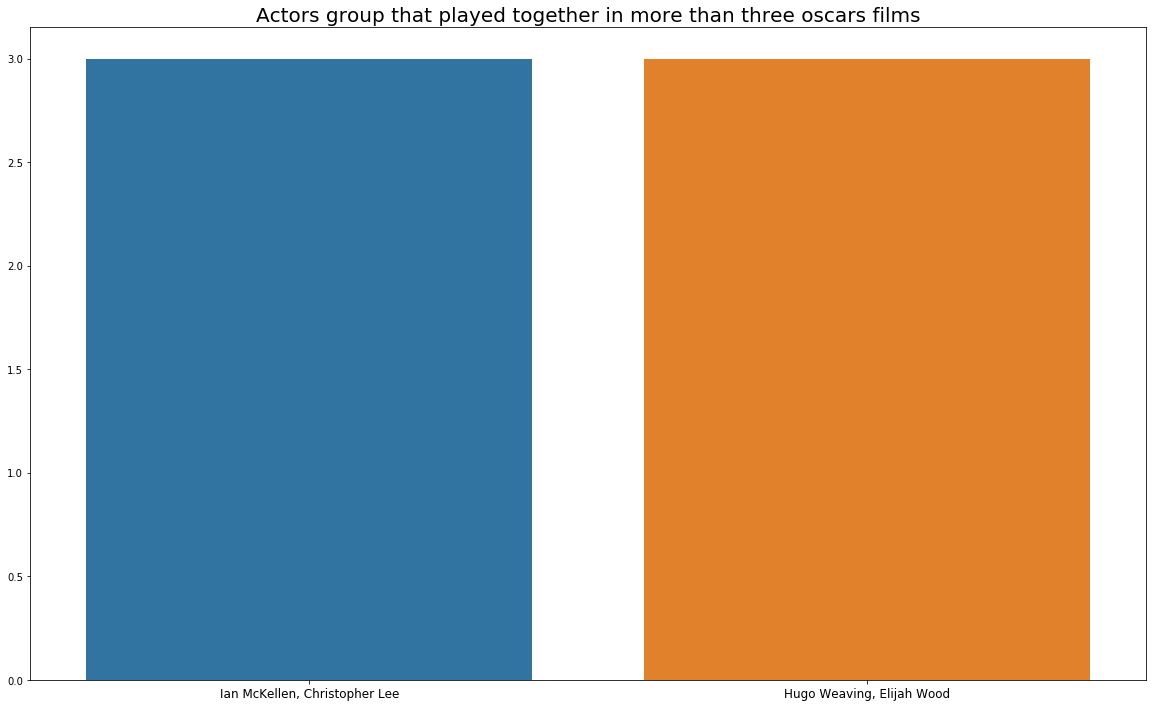

In [7]:
def calculate_support(min_occurence_number, dataset_size):
    return min_occurence_number / dataset_size

# Actors clustering for oscar movies
actorMovieDataset = oscar_movies[['id','title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset['cast']

te = TransactionEncoder()
te_ary = te.fit(actorMovieDataset).transform(actorMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=calculate_support(3,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets.sort_values('length', ascending=True)
plot_itemset("Actors group that played together in more than three oscars films", frequent_itemsets, len(df), rotation=0)

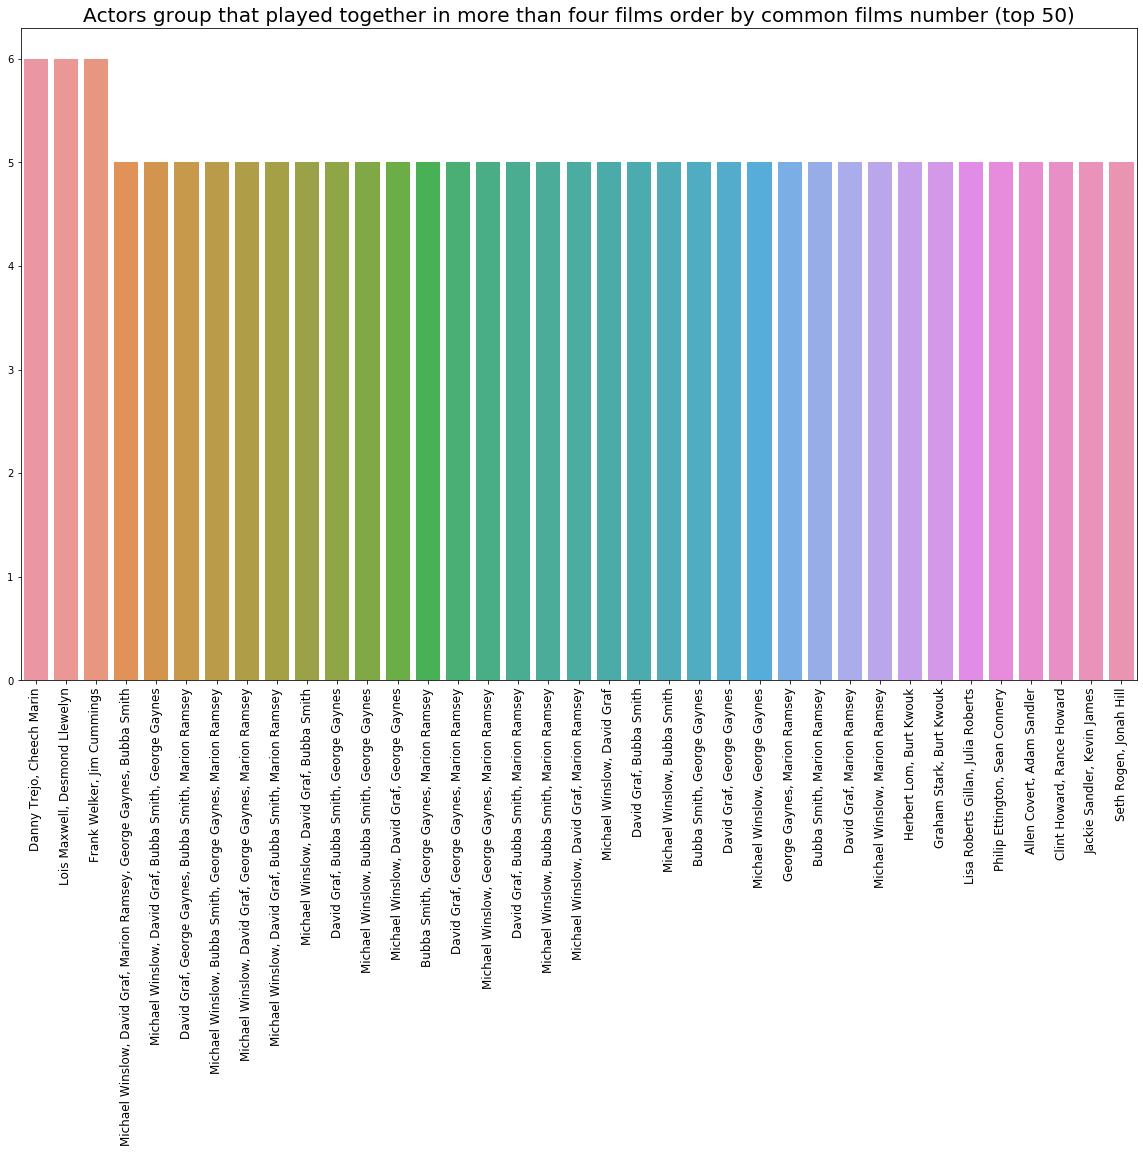

In [32]:
# Actors clustering for all movies
actorMovieDataset = dataset[['id','title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset['cast']

te = TransactionEncoder()
te_ary = te.fit(actorMovieDataset).transform(actorMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df, min_support=calculate_support(5,len(df)), max_len=5,use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Actors group that played together in more than five films order by common films number", frequent_itemsets, len(df), rotation=90)

In [ ]:
# Keywords clustering for oscar movies


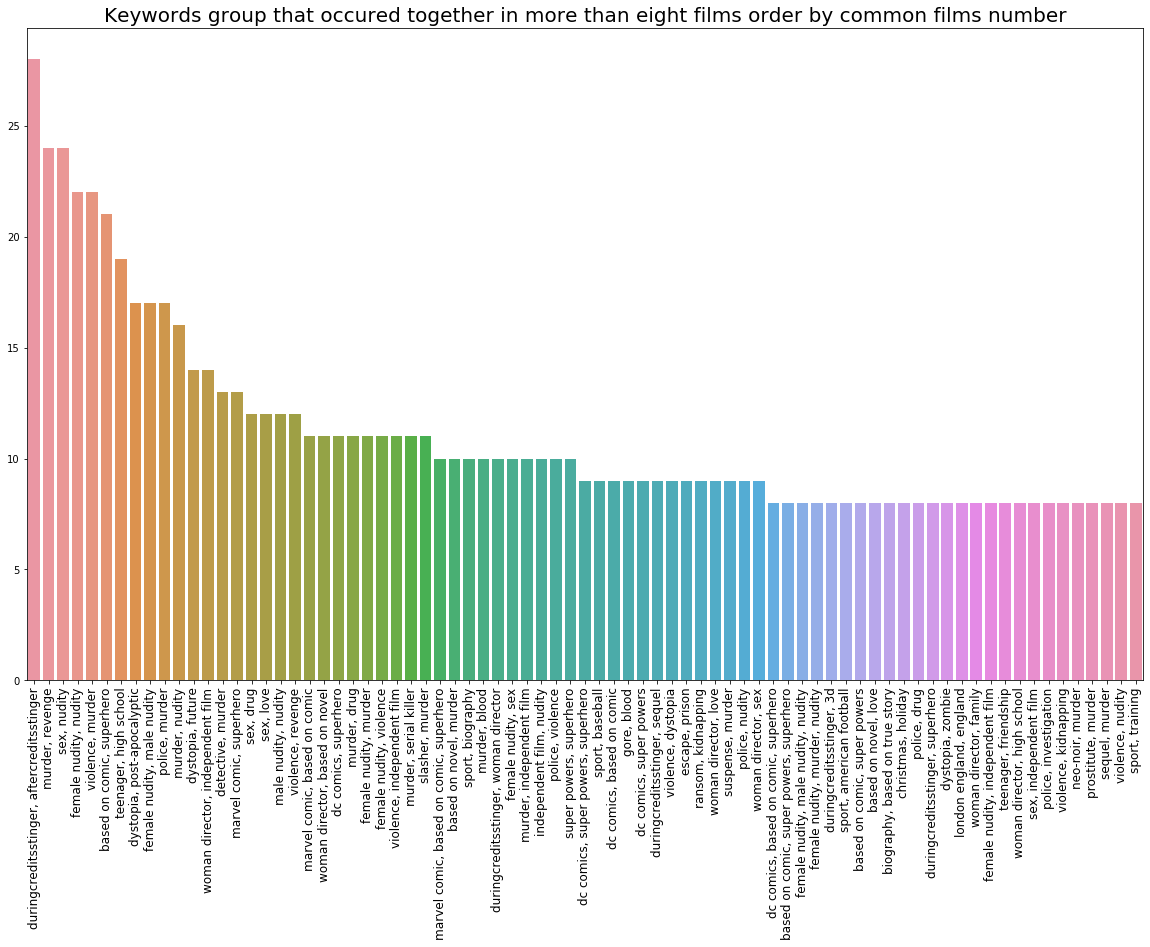

In [33]:
# Keywords clustering for all movies
keywordsMovieDataset = dataset[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset['Keywords']

te = TransactionEncoder()
te_ary = te.fit(keywordsMovieDataset).transform(keywordsMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(8,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Keywords group that occured together in more than eight films order by common films number", frequent_itemsets, len(df), rotation=90)

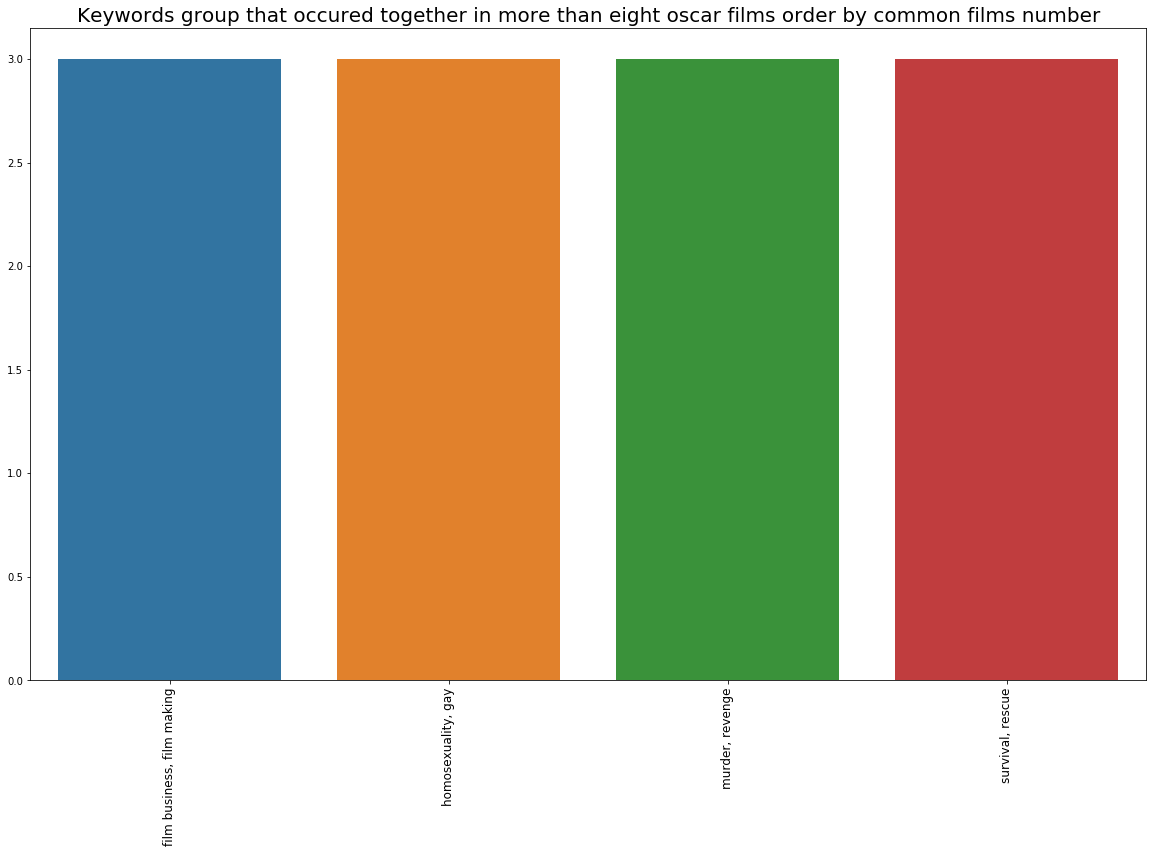

In [38]:
# Keywords clustering for oscar movies
keywordsMovieDataset = oscar_movies[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset['Keywords']

te = TransactionEncoder()
te_ary = te.fit(keywordsMovieDataset).transform(keywordsMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(3,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Keywords group that occured together in more than four oscar films order by common films number", frequent_itemsets, len(df), rotation=90)

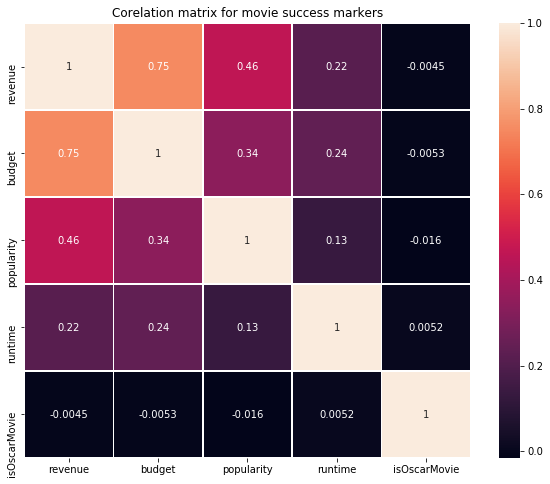

In [39]:
# Making corelation matrix
dataset['isOscarMovie'] = dataset['id'].apply(lambda x: 1 if x in oscar_movies['id'] else 0)
col = ['revenue','budget','popularity','runtime','isOscarMovie']
plt.subplots(figsize=(10, 8))
plt.title('Corelation matrix for movie success markers')
corr = dataset[col].corr()
sns.heatmap(corr, annot=True, xticklabels=col,yticklabels=col, linewidths=.5)